In [ ]:
!pip install -q lightgbm==3.3.3

In [ ]:
import numpy as np
import pandas as pd
X = pd.read_csv('https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
from sklearn.model_selection import train_test_split

# Use a utility from sklearn to split and shuffle your dataset.
X_train, X_test = train_test_split(X, test_size=0.2)

y_train = X_train['Class']
X_train = X_train.drop(['Time','Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Time','Class'], axis=1)

In [ ]:
from lightgbm import LGBMClassifier

DEFAULT_BINS = 10

def LGBMEnc(feature, target, nan = -1, n_bins = None, min_samples = 1, params = {}):
    if n_bins is None and min_samples == 1:
        n_bins = DEFAULT_BINS
    feature = feature.fillna(nan)
   
    lgbm = LGBMClassifier(
        boosting_type = 'goss',
        n_estimators = 1000, # Maximum number of iterations of the boosting process
        num_leaves = 10, # Maximum tree leaves for base learners.
        min_child_samples = min_samples, # Minimum number of data needed in a child (leaf)
        max_bin = n_bins,
        **params,
    )
    lgbm.fit( feature, target)
   
    res = lgbm.booster_.trees_to_dataframe()
   
    thresholds = {}
    for v in feature.columns:
        tmp = res.iloc[np.where(res['split_feature']== v)]
        thresholds[v] = np.sort( np.append(tmp['threshold'].unique(), feature[v].min()) ) # Append lower-Bound of binning !!!
    return thresholds

In [ ]:
thresholds = LGBMEnc(X_train, y_train, n_bins=10)

for k, v in thresholds.items():
    print(k, len(v))

V1 10
V2 10
V3 10
V4 10
V5 10
V6 10
V7 10
V8 6
V9 9
V10 10
V11 9
V12 9
V13 10
V14 9
V15 10
V16 10
V17 10
V18 9
V19 10
V20 9
V21 9
V22 10
V23 9
V24 10
V25 10
V26 10
V27 9
V28 10
Amount 10


In [ ]:
import tensorflow as tf

class LGBMPreProc(tf.keras.layers.Layer):
    def __init__(self, thold, enc_dim):
        self.thold = thold
        self.enc_dim = enc_dim
        self.lookup_table = {}
        super().__init__()
   
    def build(self, input_shape):
        for name, bins in self.thold.items():
            self.lookup_table[name] = tf.lookup.StaticHashTable(
                initializer=tf.lookup.KeyValueTensorInitializer(keys=[i for i in range(len(bins))], values=bins),
                default_value=-1
            )
        super().build(input_shape)
   
    def enc_column(self, name, x):
        n_bins = self.lookup_table[name].size().numpy()
       
        ple_encoding_one = tf.ones((tf.shape(x)[0], n_bins))
        ple_encoding_zero = tf.zeros((tf.shape(x)[0], n_bins))
 
        left_masks = tf.TensorArray(tf.bool, size=0, dynamic_size=True)
        right_masks = tf.TensorArray(tf.bool, size=0, dynamic_size=True)
        other_case = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
 
        for i in range(1, n_bins + 1):
            i = tf.constant(i)
            l = tf.math.logical_and((x < self.lookup_table[name].lookup(i - 1)) , (i > 1))
            r = tf.math.logical_and((x >= self.lookup_table[name].lookup(i)) , (i < n_bins))
            v = (x - self.lookup_table[name].lookup(i-1)) / ( self.lookup_table[name].lookup(i) - self.lookup_table[name].lookup(i-1) )
            left_masks = left_masks.write(left_masks.size(), l)
            right_masks = right_masks.write(right_masks.size(), r)
            other_case = other_case.write(other_case.size(), v)
 
        left_masks = tf.transpose(left_masks.stack())  # tf.transpose(tf.squeeze(left_masks.stack()))
        right_masks = tf.transpose(right_masks.stack())  # tf.transpose(tf.squeeze(right_masks.stack()))
        other_case = tf.transpose(other_case.stack())  # tf.transpose(tf.squeeze(other_case.stack()))
 
        other_mask = right_masks == left_masks  # both are false
        other_case = tf.cast(other_case, tf.float32)
       
        enc = tf.where(other_mask, other_case, tf.where(left_masks, ple_encoding_zero, ple_encoding_one) )
        
        #enc = tf.pad(enc, tf.constant([[0, 0,], [0, self.enc_dim-n_bins]]), "CONSTANT")
        #return tf.reshape(enc, (-1, 1, self.enc_dim))
        return enc #tf.expand_dims(enc, axis=1)
   
    def call(self, inputs, training=None):  # Defines the computation from inputs to outputs
       
        emb_columns = []
        for name in self.thold.keys():
            emb_columns.append( self.enc_column(name, inputs[name]).numpy() )
        #embs = tf.concat(emb_columns, axis=1)
        return emb_columns # embs
 
ple = LGBMPreProc(thresholds, enc_dim=10)
X_train_emb = ple(X_train, training=False)
X_test_emb = ple(X_test, training=False)

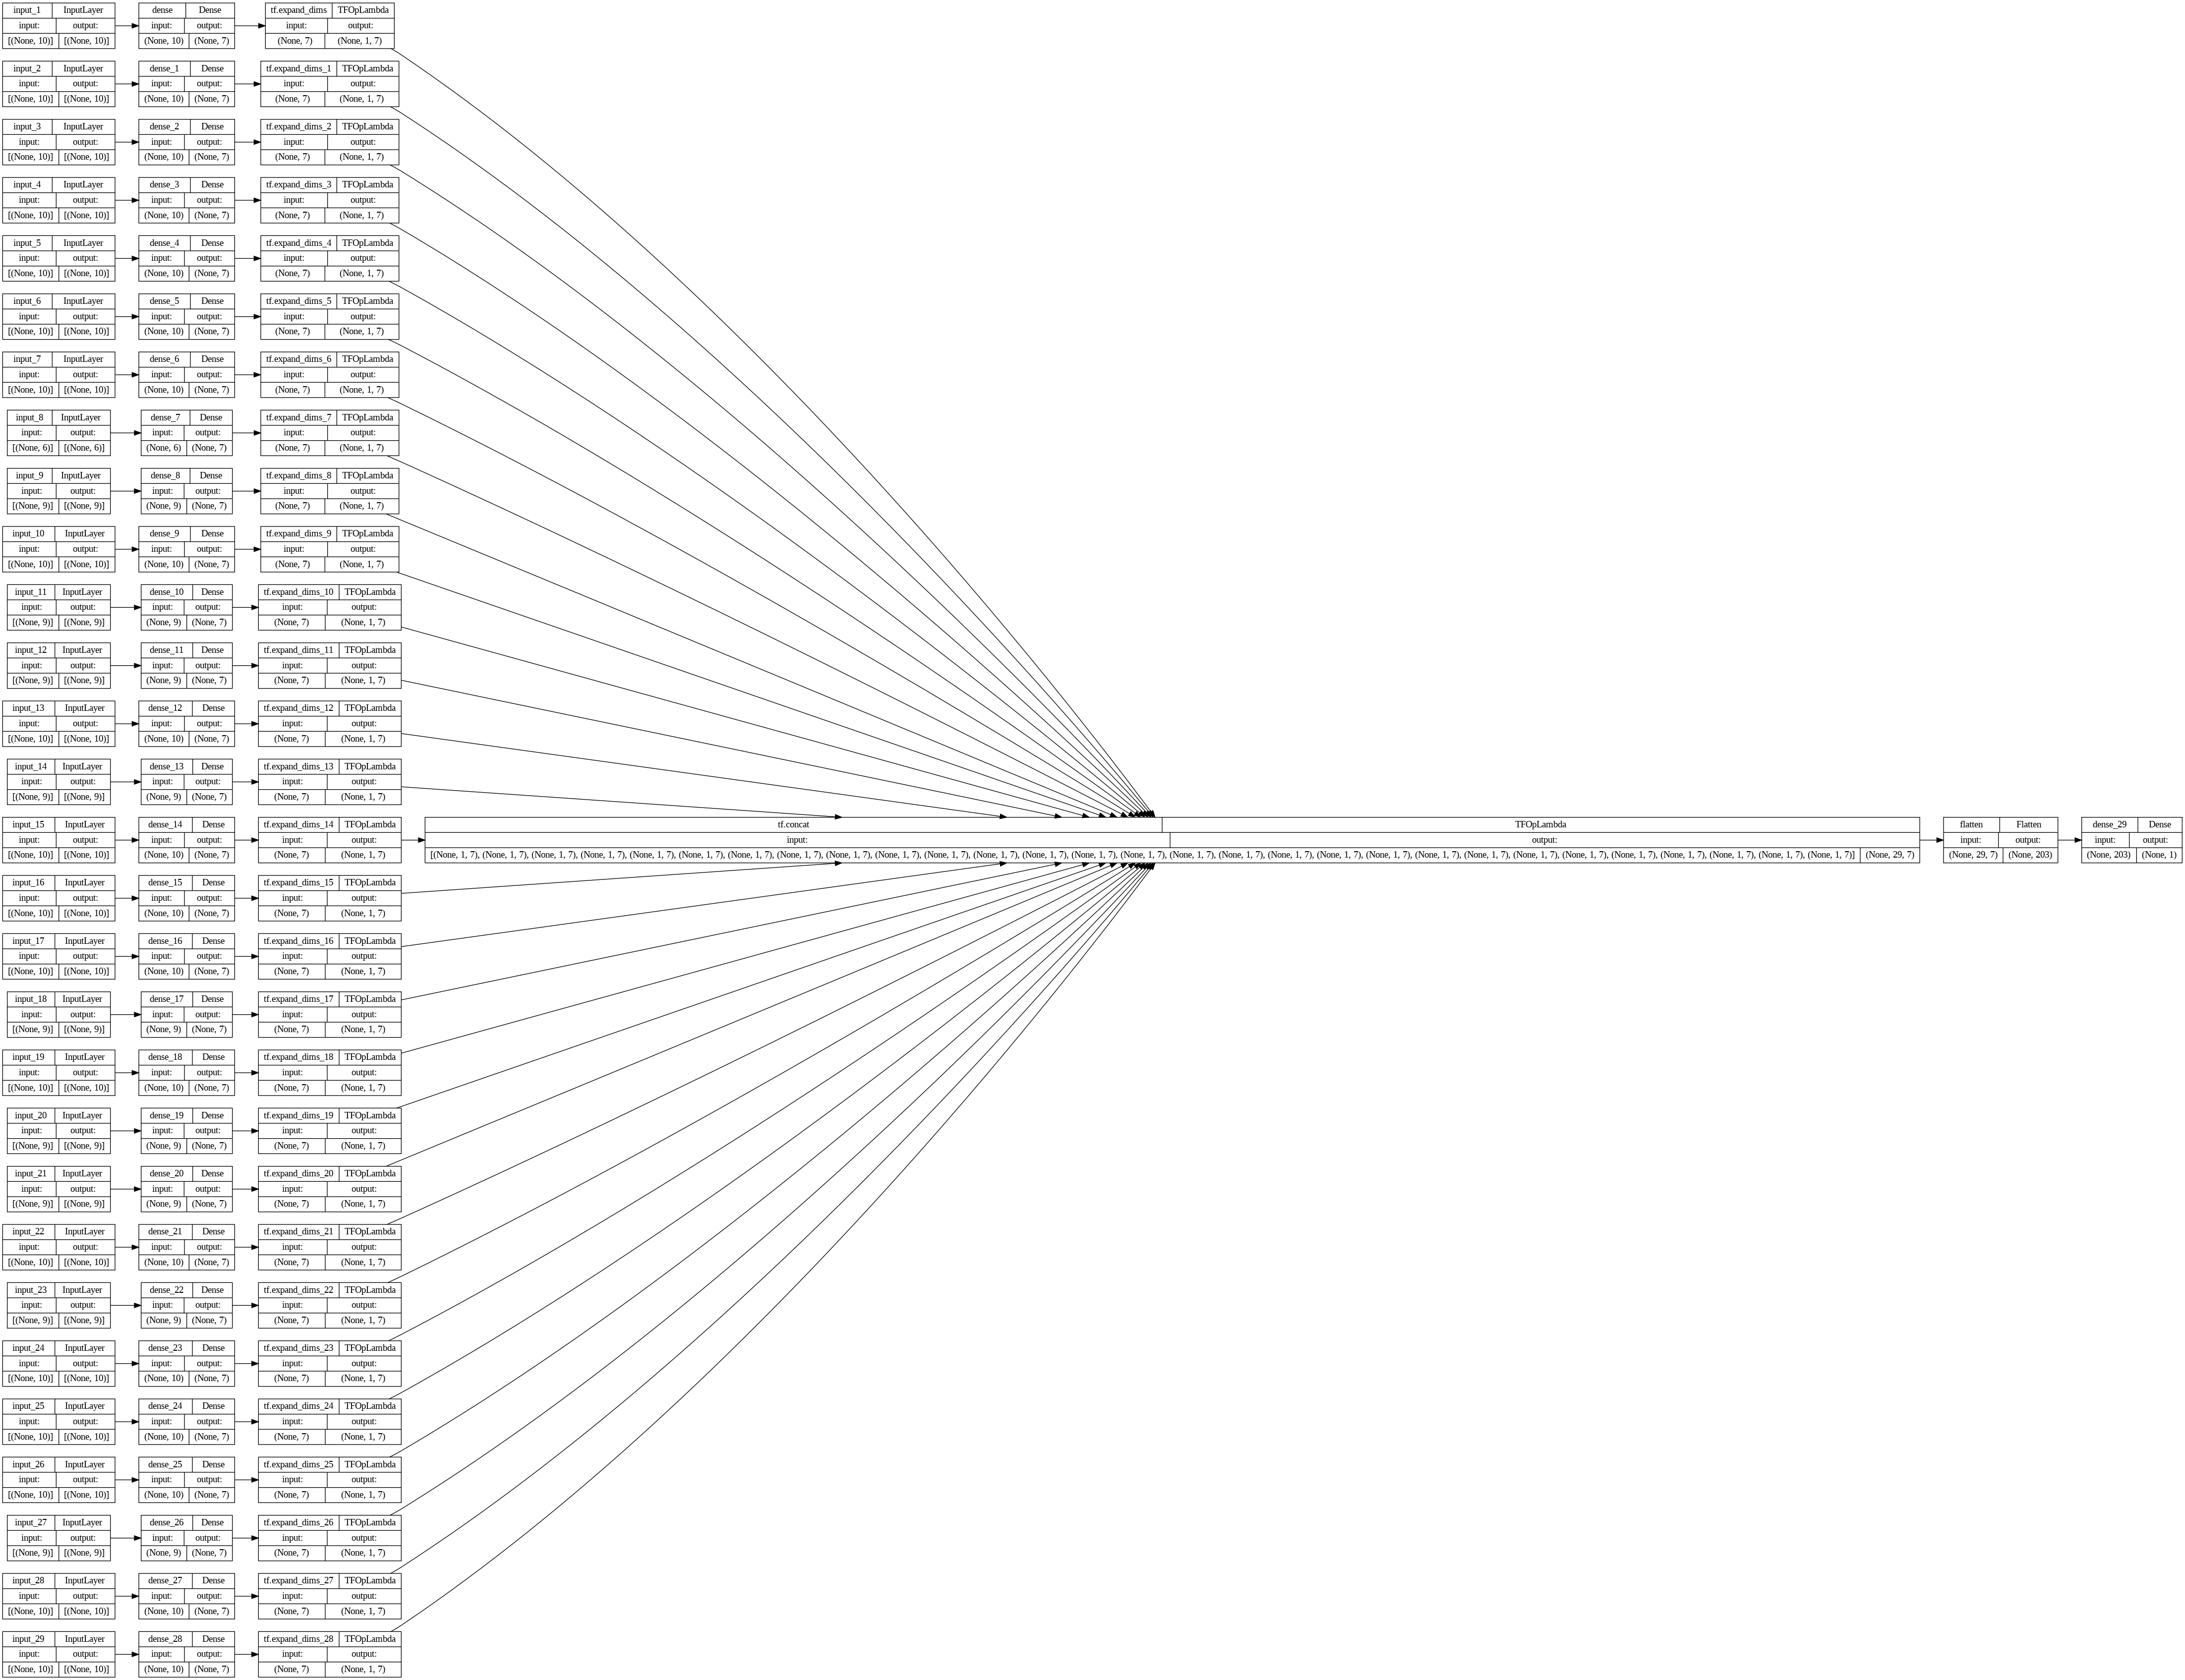

In [ ]:
inp_list = []
out_list = []
for emb in X_train_emb:
    inp = tf.keras.layers.Input(shape=(emb.shape[-1],))
    out = tf.keras.layers.Dense(7, activation='relu')(inp)
    out = tf.expand_dims(out, axis=1)
    inp_list.append(inp)
    out_list.append(out)
x = tf.concat( out_list, axis=1 )
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.Model( inputs = inp_list, outputs = x)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])

tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

hist = model.fit(
    X_train_emb,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_emb, y_test))

Epoch 1/100
112/112 [==============================] - 12s 29ms/step - loss: 0.0879 - auc: 0.6105 - val_loss: 0.0153 - val_auc: 0.7122
Epoch 2/100
112/112 [==============================] - 2s 22ms/step - loss: 0.0125 - auc: 0.7776 - val_loss: 0.0110 - val_auc: 0.7786
Epoch 3/100
112/112 [==============================] - 2s 22ms/step - loss: 0.0099 - auc: 0.8404 - val_loss: 0.0088 - val_auc: 0.8651
Epoch 4/100
112/112 [==============================] - 4s 33ms/step - loss: 0.0077 - auc: 0.8973 - val_loss: 0.0072 - val_auc: 0.8928
Epoch 5/100
112/112 [==============================] - 2s 20ms/step - loss: 0.0063 - auc: 0.9110 - val_loss: 0.0064 - val_auc: 0.9024
Epoch 6/100
112/112 [==============================] - 2s 22ms/step - loss: 0.0056 - auc: 0.9210 - val_loss: 0.0060 - val_auc: 0.9133
Epoch 7/100
112/112 [==============================] - 2s 22ms/step - loss: 0.0052 - auc: 0.9203 - val_loss: 0.0057 - val_auc: 0.9133
Epoch 8/100
112/112 [==============================] - 2s 20m